## Plotting Residual Streams

### Definitions

In [1]:
import random
from time_stuff.utils import ActivationDataset, SupervisedMDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import Normalizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import MDS
from umap import UMAP
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.patheffects as pe
from pycolormap_2d import ColorMap2DZiegler

In [2]:
# General script for plotting activations
def datetime_to_dayofyear(x):
    # Convert to datetime
    x = pd.to_datetime(x)
    # Get the day of the year
    return x.day_of_year

def datetime_to_month(x):
    # Convert to datetime
    x = pd.to_datetime(x)
    # Get the month
    return x.month

def farthest_point_sampling(X, k, noise=0.1):
    n_points = X.shape[0]
    selected_indices = [np.random.randint(n_points)]
    distances = np.full(n_points, np.inf)

    for _ in range(1, k):
        last_selected = X[selected_indices[-1]]
        dist_to_last = np.linalg.norm(X - last_selected, axis=1)
        distances = np.minimum(distances, dist_to_last)
        # Add noise to distances proportional to their magnitude
        distances += noise * np.abs(distances) * np.random.rand(n_points)
        next_index = np.argmax(distances)
        selected_indices.append(next_index)

    return selected_indices

def plot_activations(ad: ActivationDataset, label_col: str, reduction_method, target_col='correct_answer', layers=None, components=(0,1),
                     label_col_str=None, n_components=2, manifold='discrete_circular', title=None, save_path=None, preprocess_func=None, plots_per_row=4,
                     annotations='random', annotation_preprocess_func=None, filter_incorrect=True, orthonormal=False):
    if len(layers) < plots_per_row:
        plots_per_row = len(layers)

    normalizer = Normalizer()

    if reduction_method == 'PCA':
        rmodel = PCA(n_components=n_components)
    elif reduction_method == 'tSNE':
        rmodel = TSNE(n_components=n_components)
    elif reduction_method == 'Isomap':
        rmodel = Isomap(n_components=n_components)
    elif reduction_method == 'PLS':
        rmodel = PLSRegression(n_components=n_components)
    elif reduction_method == 'LDA':
        rmodel = LinearDiscriminantAnalysis(n_components=n_components)
    elif reduction_method == 'SMDS':
        rmodel = SupervisedMDS(n_components=n_components, manifold=manifold, orthonormal=orthonormal)
    elif reduction_method == 'UMAP':
        rmodel = UMAP(n_components=n_components)
    elif reduction_method == 'MDS':
        rmodel = MDS(n_components=n_components)
    
    activations, labels = ad.get_slice(target_name=target_col, columns=label_col, preprocess_funcs=preprocess_func, filter_incorrect=filter_incorrect)
    labels = np.squeeze(labels)

    df = ad.get_metadata_df(filter_incorrect=filter_incorrect)

    # Split train and test sets
    split = 0.5
    activations_train = activations[:int(len(activations)*split)]
    activations_dev = activations[int(len(activations)*split):]

    labels_train = labels[:int(len(labels)*split)]
    labels_dev = labels[int(len(labels)*split):]

    df_train = df.iloc[:int(len(df)*split)].reset_index(drop=True)
    df_dev = df.iloc[int(len(df)*split):].reset_index(drop=True)

    # Standardize labels to 0-1 range
    if reduction_method in ['PLS']:
        min_label = labels_train.min()
        max_label = labels_train.max()
        labels_train = (labels_train-min_label)/(max_label-min_label)
        labels_dev = (labels_dev-min_label)/(max_label-min_label)

    if layers is None:
        layers = range(activations.shape[1])

    # Plot the data
    scaling_factor = 6 if len(layers) > 1 else 8
    fig, axs = plt.subplots(int(np.ceil(len(layers)/plots_per_row)), plots_per_row, figsize=(scaling_factor*plots_per_row, scaling_factor*len(layers)//plots_per_row), constrained_layout=True)

    for i, layer in tqdm(enumerate(layers)):
        if plots_per_row > 1:
            ax = axs[i//plots_per_row][i%plots_per_row]
        elif len(layers) > 1:
            ax = axs[i]
        else:
            ax = axs

        activations_layer_train = activations_train[:, layer]
        activations_layer_dev = activations_dev[:, layer]

        if reduction_method in ['PCA']:
            activations_layer_train = normalizer.fit_transform(activations_layer_train)
            activations_layer_dev = normalizer.transform(activations_layer_dev)
        
        if reduction_method in ['MDS']:
            activations_reduced_dev = rmodel.fit_transform(activations_layer_dev)
        else:
            # Fit the model
            rmodel.fit(activations_layer_train, labels_train)
            # Transform the data
            activations_reduced_train = rmodel.transform(activations_layer_train)
            activations_reduced_dev = rmodel.transform(activations_layer_dev)
        
        if reduction_method == 'LDA' and activations_reduced_dev.shape[1] <= 1:
            print(f"Layer {layer} has collinear centroids. Skipping.")
            continue
        
        if labels_dev.ndim > 1:
            # If labels are multi-dimensional, map them to 0-1 range
            cmap_labels_dev = (labels_dev - labels_dev.min(axis=0)) / (labels_dev.max(axis=0) - labels_dev.min(axis=0))
            # Use ColorMap2DZiegler to get bidimensional colors
            cmap = ColorMap2DZiegler()
            hues = [cmap(l1,l2) / 255.0 for l1, l2 in cmap_labels_dev]

            # Plot the data
            ax.scatter(activations_reduced_dev[:, components[0]], activations_reduced_dev[:, components[1]], c=hues, s=20)

        else:
            hues = labels_dev
            # Plot the data
            palette = 'viridis' if len(np.unique(hues)) > 2 else ['#3A4CC0', '#B40426']#['blue', 'red']
            sns.scatterplot(x=activations_reduced_dev[:, components[0]], y=activations_reduced_dev[:, components[1]], 
                            hue=hues, ax=ax, palette=palette, alpha=1.0)
            ax.get_legend().set_visible(False)
        # Set title
        ax.set_title(f"Layer {layer}")

        if reduction_method not in ['UMAP', 'MDS']:
            print(f"Layer: {layer} Score: {rmodel.score(activations_layer_dev, labels_dev)}")

        if label_col_str is not None:
            if annotations == 'random':
                # Select a few random sentences
                indices = np.random.choice(len(activations_layer_dev), size=10, replace=False)
                rnd_activations = activations_reduced_dev[indices]
                txt = df_dev.iloc[indices][label_col_str].values

                points = rnd_activations

            elif annotations == 'uniform':
                indices = farthest_point_sampling(activations_reduced_dev, 15)
                rnd_activations = activations_reduced_dev[indices]
                txt = df_dev.iloc[indices][label_col_str].values

                points = rnd_activations

            elif annotations == 'class':
                # Select sentences so that they represent one item per class in label_col_str
                unique_labels = df_dev[label_col_str].unique()
                indices = []
                for label in unique_labels:
                    # Get the index of the first occurrence of the label
                    idx = df_dev[df_dev[label_col_str] == label].index[0]
                    indices.append(idx)
                
                # Get the activations and sentences for the selected indices
                rnd_activations = activations_reduced_dev[indices]
                txt = df_dev.iloc[indices][label_col_str].values

                points = rnd_activations


            elif annotations=='centroids':
                # Compute the centroids of each class
                centroids = []
                unique_labels = np.unique(labels_dev)
                
                # Cap the number of centroids to 12
                if unique_labels.shape[0] > 16:
                    unique_labels = np.random.choice(unique_labels, size=16, replace=False)

                for label in unique_labels:
                    # Get the indices of the samples with the current label
                    indices = np.where(labels_dev == label)[0]
                    # Compute the centroid of the samples with the current label
                    centroid = np.mean(activations_reduced_dev[indices], axis=0)
                    centroids.append(centroid)
                centroids = np.array(centroids)

                # Compute the corresponding txt
                txt = []
                for label in unique_labels:
                    # Get the indices of the samples with the current label
                    indices = np.where(labels_dev == label)[0]
                    # Get the first sample with the current label
                    txt.append(df_dev.iloc[indices[0]][label_col_str])
                points = centroids

            else:
                raise ValueError("Invalid annotations value. Use 'random', 'class' or 'centroids'.")

            # Plot the points
            ax.scatter(points[:, components[0]], points[:, components[1]], color='red', edgecolor='k', s=20)

            if annotation_preprocess_func is not None:
                # Preprocess the text
                txt = [annotation_preprocess_func(t) for t in txt]

            # Annotate the points
            for j, txt in enumerate(txt):
                ax.annotate(txt, (points[j, components[0]], points[j, components[1]]), fontsize=16,  path_effects=[pe.withStroke(linewidth=2, foreground="white")])


    # Set the title
    if title is not None:
        fig.suptitle(title, fontsize=20)
    else:
        fig.suptitle(f"{reduction_method} - {ad.model_name} - {ad.dataset_name}", fontsize=20)

    
    # plt.tight_layout()
    if not save_path:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)


### Dates

0.8087349397590361


1it [00:05,  5.80s/it]

Layer: 0 Score: 0.0


2it [00:08,  3.76s/it]

Layer: 3 Score: 0.3567088999605341


3it [00:14,  4.76s/it]

Layer: 7 Score: 0.5869010137962334


4it [00:16,  3.95s/it]

Layer: 10 Score: 0.5963842282882318


5it [00:22,  4.41s/it]

Layer: 14 Score: 0.6079465606700822


6it [00:23,  3.38s/it]

Layer: 18 Score: 0.3257730706868387


7it [00:28,  4.09s/it]

Layer: 21 Score: 0.24673156472986768


8it [00:30,  3.38s/it]

Layer: 25 Score: -2.0448089494568484


9it [00:31,  3.48s/it]

Layer: 28 Score: -22.91471383775864


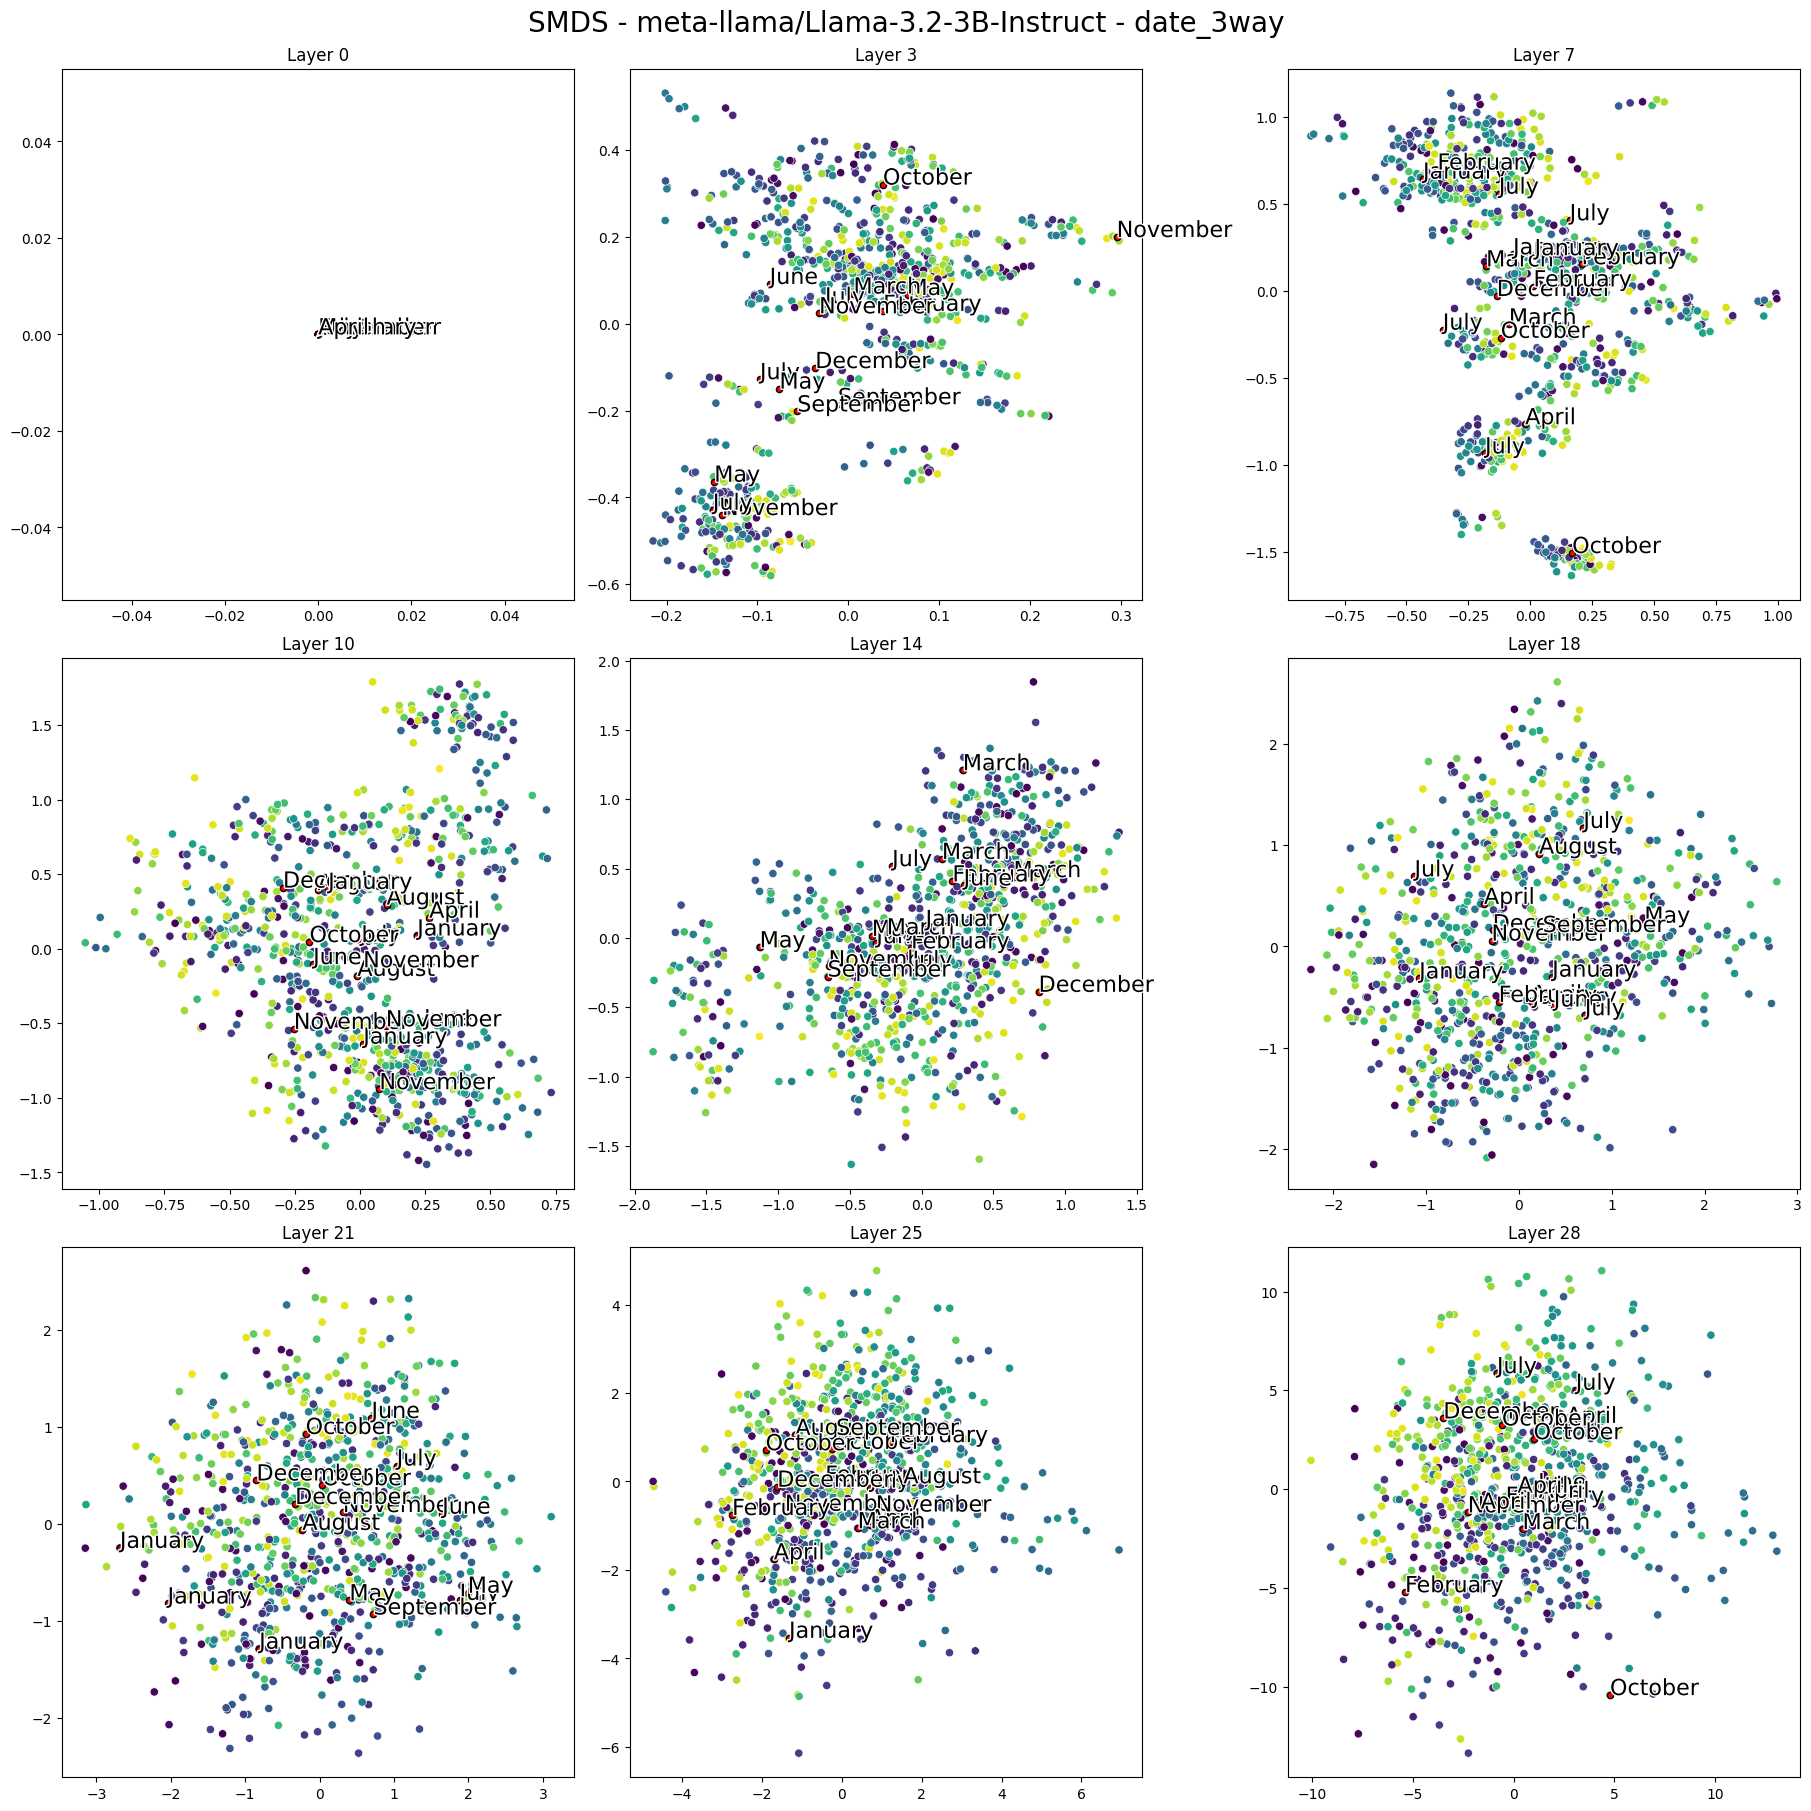

In [21]:
linspace = np.linspace(0, 1, 9)

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_season.pt')
# # # layers = range(0, ad.n_layers, )
# layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# # layers = [14]
# plot_activations(ad, label_col='correct_season_label', layers=layers, reduction_method='SMDS', label_col_str='correct_season',
#                  plots_per_row=2, annotations='centroids', manifold='euclidean', n_components=3)

ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way.pt')
# ad = ActivationDataset.load('results/gpt2/date_1way.pt')
print(ad.get_accuracy())
# layers = range(0, ad.n_layers, 4)
layers = [int(np.clip(ad.n_layers * p, a_min=0, a_max=ad.n_layers-1)) for p in linspace]
# layers = [8]
plot_activations(ad, label_col='correct_date', target_col='last_prompt_token', layers=layers, reduction_method='SMDS',
                 label_col_str='correct_date', orthonormal=True,
                 preprocess_func=datetime_to_dayofyear, plots_per_row=3, manifold='circular', annotations='centroids',
                 filter_incorrect=True, annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'))

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_2hop.pt')
# print(ad.get_accuracy())
# # layers = range(0, ad.n_layers, 4)
# layers = [int(np.clip(ad.n_layers * p, a_min=0, a_max=ad.n_layers-1)) for p in linspace]
# plot_activations(ad, label_col='correct_date', layers=layers, reduction_method='SMDS', label_col_str='correct_date', 
#                  preprocess_func=datetime_to_dayofyear, plots_per_row=3, manifold='euclidean')

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_temperature.pt')
# print(ad.get_accuracy())
# # layers = range(0, ad.n_layers, 2)
# layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# # layers = [14]
# # plot_activations(ad, label_col='correct_temperature_label', layers=layers, reduction_method='SMDS', 
# #                  target_col='last_prompt_token',
# #                  label_col_str='correct_date', manifold='discrete_circular', plots_per_row=3, 
# #                  annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'))
# plot_activations(ad, label_col='correct_temperature_label', layers=layers, reduction_method='SMDS', 
#                  target_col='correct_answer',
#                  label_col_str='correct_date', manifold='log_linear', plots_per_row=3, 
#                  annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'))

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_month.pt')
# # layers = range(0, ad.n_layers, 4)
# layers = [int(np.clip(ad.n_layers * p, a_min=0, a_max=ad.n_layers-1)) for p in linspace]
# # layers = [19]
# # plot_activations(ad, label_col='correct_date', layers=layers, reduction_method='PLS', label_col_str='correct_month', 
# #                  manifold='euclidean', preprocess_func=datetime_to_dayofyear)
# plot_activations(ad, label_col='correct_month_label', layers=layers, reduction_method='SMDS', label_col_str='correct_month', 
#                  manifold='discrete_circular', plots_per_row=3, annotations='centroids')

### Time of day

In [ ]:
linspace = np.linspace(0, 1, 9)

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/time_of_day_HH:MM.pt')
# # layers = range(1, ad.n_layers, 1)
# layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# # layers = [8]
# plot_activations(ad, label_col='correct_hour', layers=layers, reduction_method='SMDS', label_col_str='correct_answer', annotations='uniform',
#                  plots_per_row=4, manifold='discrete_circular' )

ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/time_of_day_3way.pt')
print(ad.get_accuracy())
# layers = range(1, ad.n_layers, 1)
layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# layers = [18]
plot_activations(ad, label_col='correct_time', target_col='correct_date_str', layers=layers, reduction_method='SMDS', label_col_str='correct_time', annotations='centroids',
                 plots_per_row=4, manifold='circular', preprocess_func=lambda x: pd.to_datetime(x).hour, filter_incorrect=True,
                 annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%H:%M'), n_components=3)

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/time_of_day_3way_phase.pt')
# print(ad.get_accuracy())
# # layers = range(1, ad.n_layers, 1)
# layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# # layers = [8]
# plot_activations(ad, label_col='correct_phase_label', layers=layers, reduction_method='SMDS', label_col_str='correct_time', annotations='random',
#                  plots_per_row=4, manifold='discrete_circular')

0.299


KeyError: 'correct_time_str'

### Periodic, Duration, Notable

0.2966666666666667


1it [00:02,  2.89s/it]

Layer: 1 Score: 0.24405952606810388


2it [00:05,  2.83s/it]

Layer: 3 Score: 0.011561577289304181


3it [00:06,  1.91s/it]

Layer: 7 Score: -2.039639064674568


4it [00:09,  2.34s/it]

Layer: 10 Score: -6.38905069872249


5it [00:10,  1.92s/it]

Layer: 14 Score: -4.746480709848492


6it [00:13,  2.25s/it]

Layer: 18 Score: -11.31207160340783


7it [00:16,  2.41s/it]

Layer: 21 Score: -18.997526053389702


8it [00:18,  2.39s/it]

Layer: 25 Score: -28.183244770248507


9it [00:21,  2.35s/it]

Layer: 28 Score: -263.2957797459096


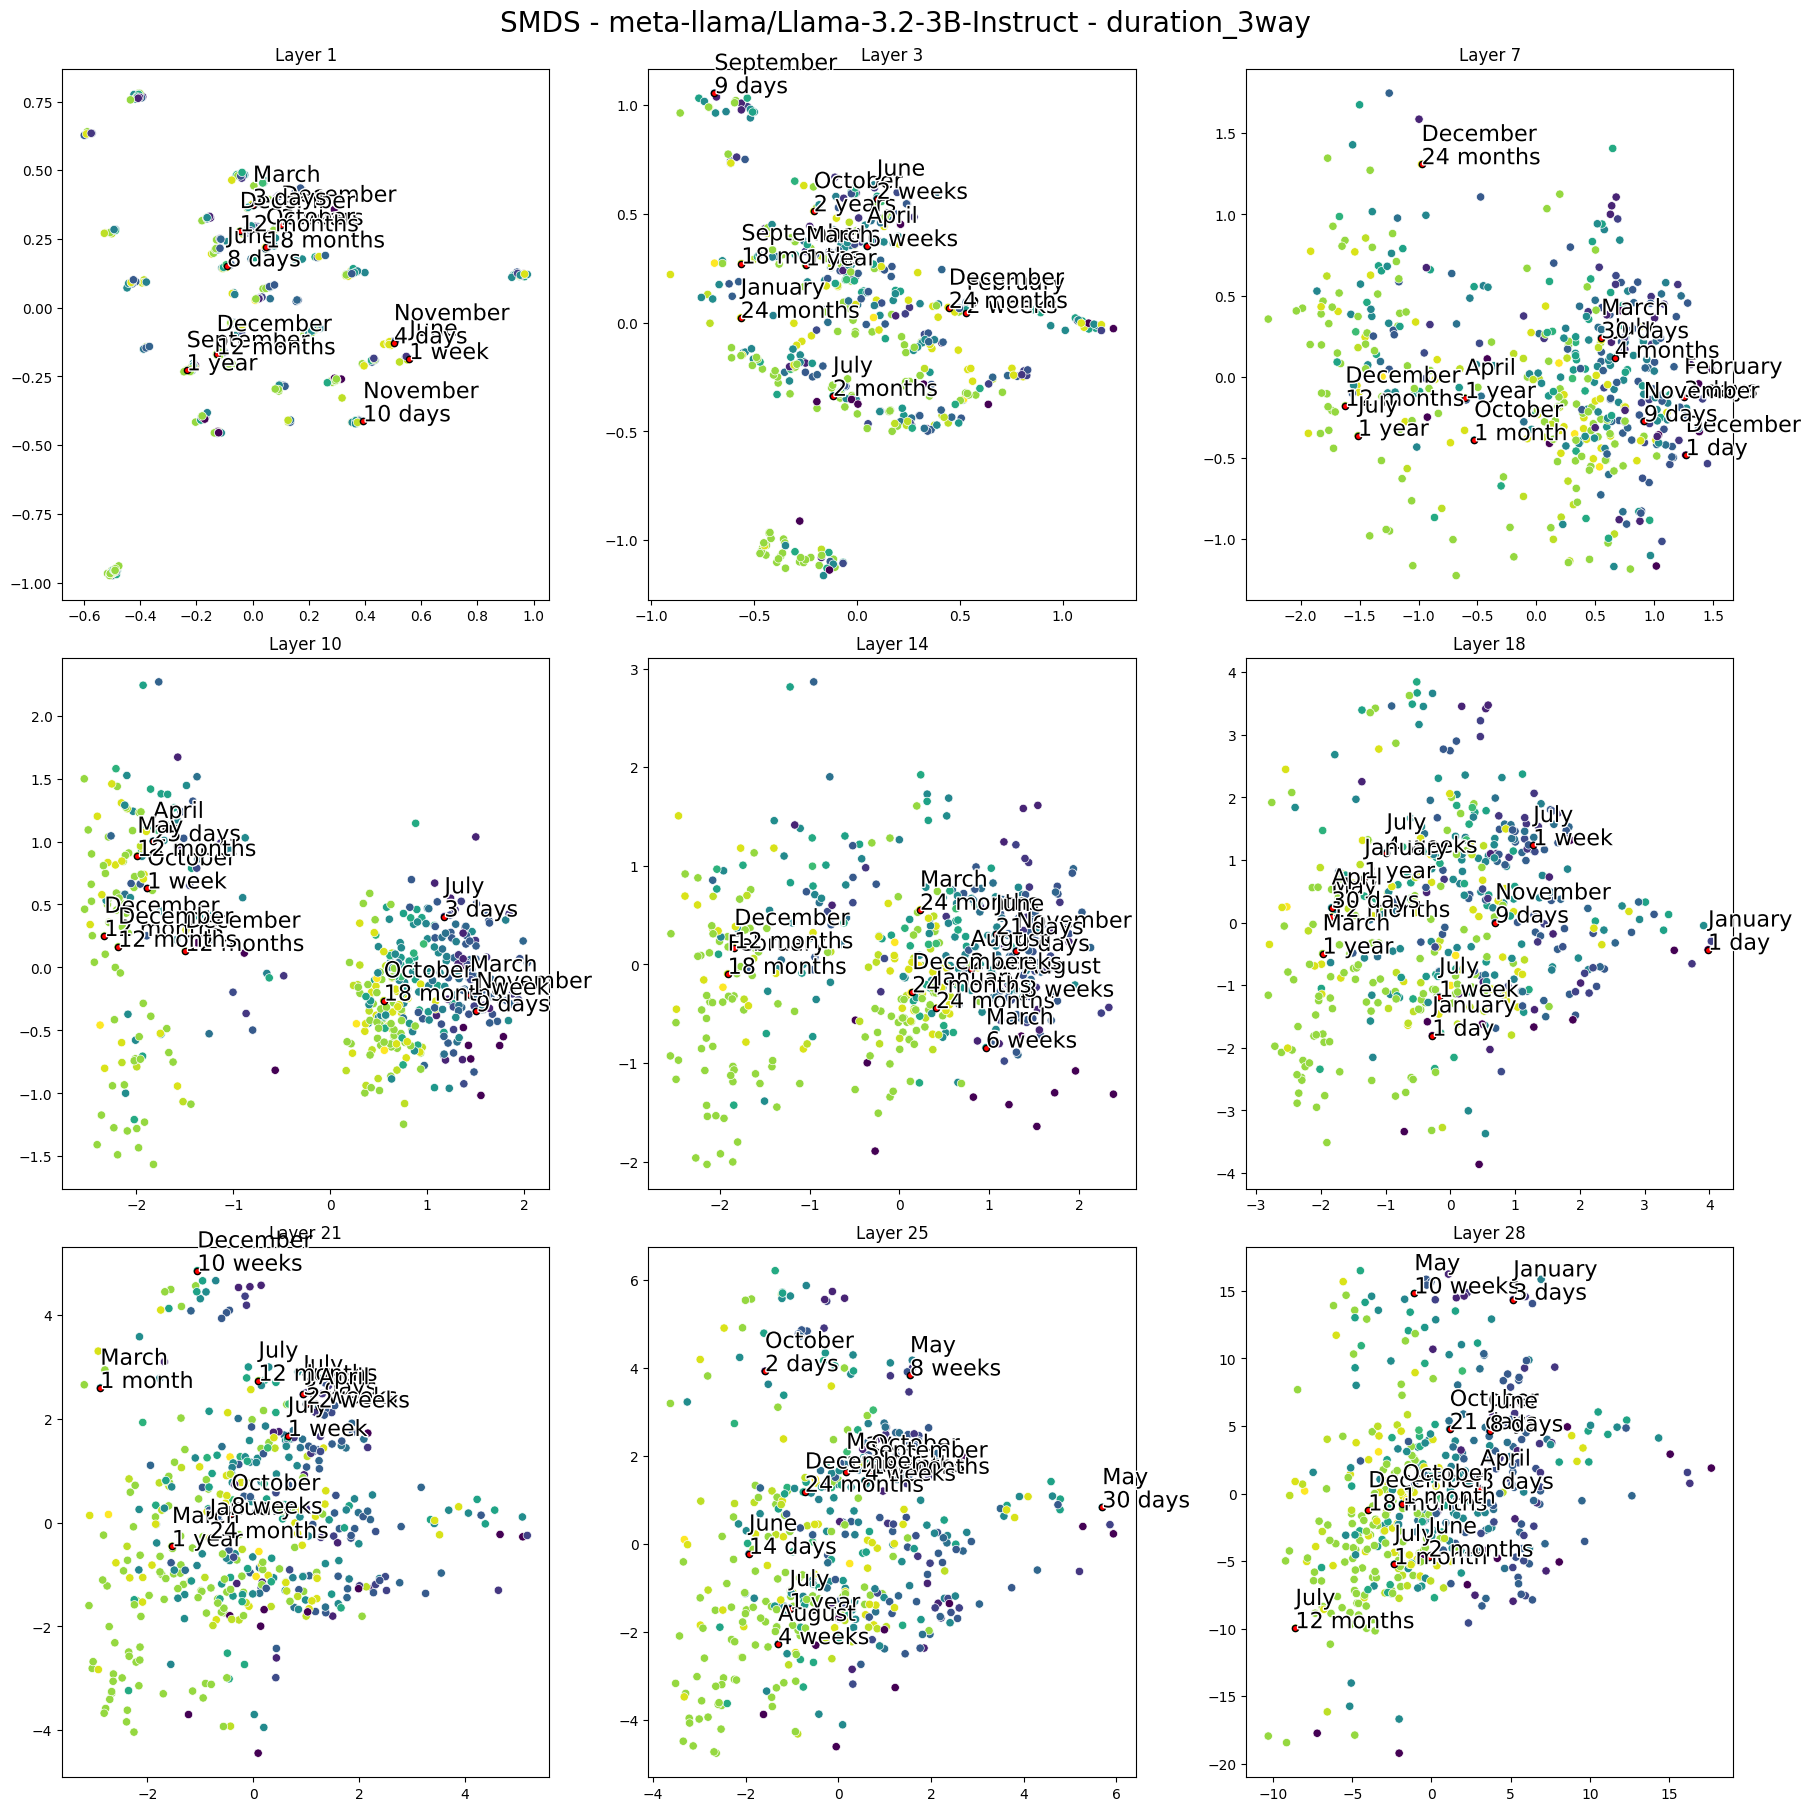

In [4]:
linspace = np.linspace(0, 1, 9)

# ad = ActivationDataset.load('results/gpt2/duration_3way.pt')
ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/duration_3way.pt')
layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# layers = range(1, ad.n_layers, 3)
# # layers = [3, 11, 18, 27]
print(ad.get_accuracy())
# plot_activations(ad, label_col=['correct_duration_length', 'correct_date'], layers=layers, reduction_method='SMDS', plots_per_row=3,
#                  label_col_str=['correct_month', 'correct_duration_str'], preprocess_func=[lambda x: np.log(x), datetime_to_dayofyear], manifold='euclidean', 
#                  annotations='random', annotation_preprocess_func=lambda x: x[0] + '\n' + x[1], n_components=10)
plot_activations(ad, label_col=['correct_duration_length'], target_col='correct_answer', layers=layers, reduction_method='SMDS', plots_per_row=3,
                 label_col_str=['correct_month', 'correct_duration_str'], preprocess_func=lambda x: np.log(x), manifold='log_linear', annotations='random',
                 annotation_preprocess_func=lambda x: x[0] + '\n' + x[1], filter_incorrect=True, orthonormal=True)


# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/periodic_3way.pt')
# layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# # layers = range(1, ad.n_layers, 3)
# # # layers = [3, 11, 18, 27]
# print(ad.get_accuracy())
# plot_activations(ad, label_col='correct_period_length', layers=layers, reduction_method='SMDS', plots_per_row=3,
#                  label_col_str='correct_period_str', preprocess_func=lambda x: np.log(x), manifold='euclidean', annotations='random',
#                  filter_incorrect=True, orthonormal=True)
# plot_activations(ad, label_col='correct_period_length', layers=layers, reduction_method='SMDS', plots_per_row=3,
#                  label_col_str='correct_period_str', manifold='circular', annotations='random',
#                  filter_incorrect=True, orthonormal=True,)


# ad = ActivationDataset.load('results/gpt2/notable_3way.pt')
# print(ad.get_metadata_df()['answer'])
# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/notable_3way.pt')
# # # layers = range(0, ad.n_layers, 2)
# layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# min_date = pd.to_datetime(ad.get_metadata_df()['correct_date']).min()
# max_date = pd.to_datetime(ad.get_metadata_df()['correct_date']).max()
# min_year = min_date.year
# max_year = max_date.year
# # Normalize the dates to a 0-1 range. Dates are across the 20th century
# preprocess_func = lambda x: (pd.to_datetime(x) - min_date).total_seconds() / (max_date - min_date).total_seconds()
# # plot_activations(ad, label_col='correct_date', layers=layers, reduction_method='SMDS', label_col_str='correct_date',
# #                  manifold='euclidean', preprocess_func=lambda x: np.log((pd.to_datetime(x).year - min_year)/1000 + 1), plots_per_row=3, n_components=3, components=(0,1),
# #                  annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%Y'), annotations='uniform',)
# plot_activations(ad, label_col='correct_date', layers=layers, reduction_method='SMDS', label_col_str='correct_date',
#                  manifold='log_linear', preprocess_func=lambda x: np.abs(pd.to_datetime(x).year - 2023), plots_per_row=3, n_components=3, components=(0,1),
#                  annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%Y'), annotations='centroids', orthonormal=True)

# Need a way to distinguish runs made with the same manifold but with a different preprocess_func
